# MSIN0097 Individual Coursework assignment

# Candidate Number: DXKP8

# Word Count : 1960


# Brain Tumor Fit/Predict Using Neural Network

#### Brain tumor is considered to be one of the most aggressive diseases affecting both children and adults. Each year, approximately 11,700 people receive a diagnosis of a brain tumor. The 5-year survival rate for cancerous brain or CNS tumors is around 34 percent for men and 36 percent for women. Currently, Magnetic Resonance Imaging (MRI) is the most effective technique for detecting brain tumors as it generates a large amount of image data that requires examination by radiologists. However, due to the complexities involved in brain tumors and their properties that make manual examination and diagnosis challenging, there may be room for improvement in reliability and accuracy.

#### Brain tumors pose challenges due to their diverse sizes and locations, complicating a comprehensive understanding of their nature. Plus, Analyzing MRI scans typically requires the expertise of a professional neurosurgeon. However, In developing countries, limited skilled practitioners and insufficient tumor-related knowledge can cause delays and difficulties in interpreting MRI results, thus let patients miss their optimal treatment period.

#### Given these circumstances, it is worthwhile to utilize machine learning classification techniques in order to develop a model capable of detecting and predicting brain tumors. This approach would lead to a reduction in the cost of diagnosing brain tumors, while also enabling radiologists and physicians to conduct more accurate diagnoses with the assistance of the model.


In [2]:
# Imports
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image


# Import the dataset, set different paths for training and testing

In [3]:
# Import data 
dir0='BT_dataset/Training'
dir2='BT_dataset/Testing'

In [4]:
# Initialize two empty lists to hold class names and paths for training data
classes = []
paths = []

# Walk through the directory specified by dir0
# os.walk generates a list of file names in a directory tree
for dirname, _, filenames in os.walk(dir0):
    for filename in filenames:
        # Extract the class name from the directory name
        # This assumes the class name is the last part of the directory path
        classes += [dirname.split('/')[-1]]
        # Create a full file path by joining directory name and filename and add to the paths list
        paths += [(os.path.join(dirname, filename))]

# Same, create two empty lists to hold class names and paths for testing data
tclasses = []
tpaths = []

# Repeat the process for the directory specified by dir2
for dirname, _, filenames in os.walk(dir2):
    for filename in filenames:
        
        # Extract the class name and create the full file path for testing data
        tclasses += [dirname.split('/')[-1]]
        tpaths += [(os.path.join(dirname, filename))]


In [5]:
# Print the class names and paths to double check
print(tclasses)

print(tpaths)

['Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor', 'Testing\\glioma_tumor',

## Data Exploration 

####  We start with some basic explorations for the dataset, the datase is organized into a training set and a testing set already, which are further divided into categories representing three different types of tumors 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', along with a category for images without a tumor.

##### Before we going further of data exploration, we need to perform a visual inspection for this dataset, the following code take the training data split as a sample and randomly select a few images from each folder to display for the visual check.

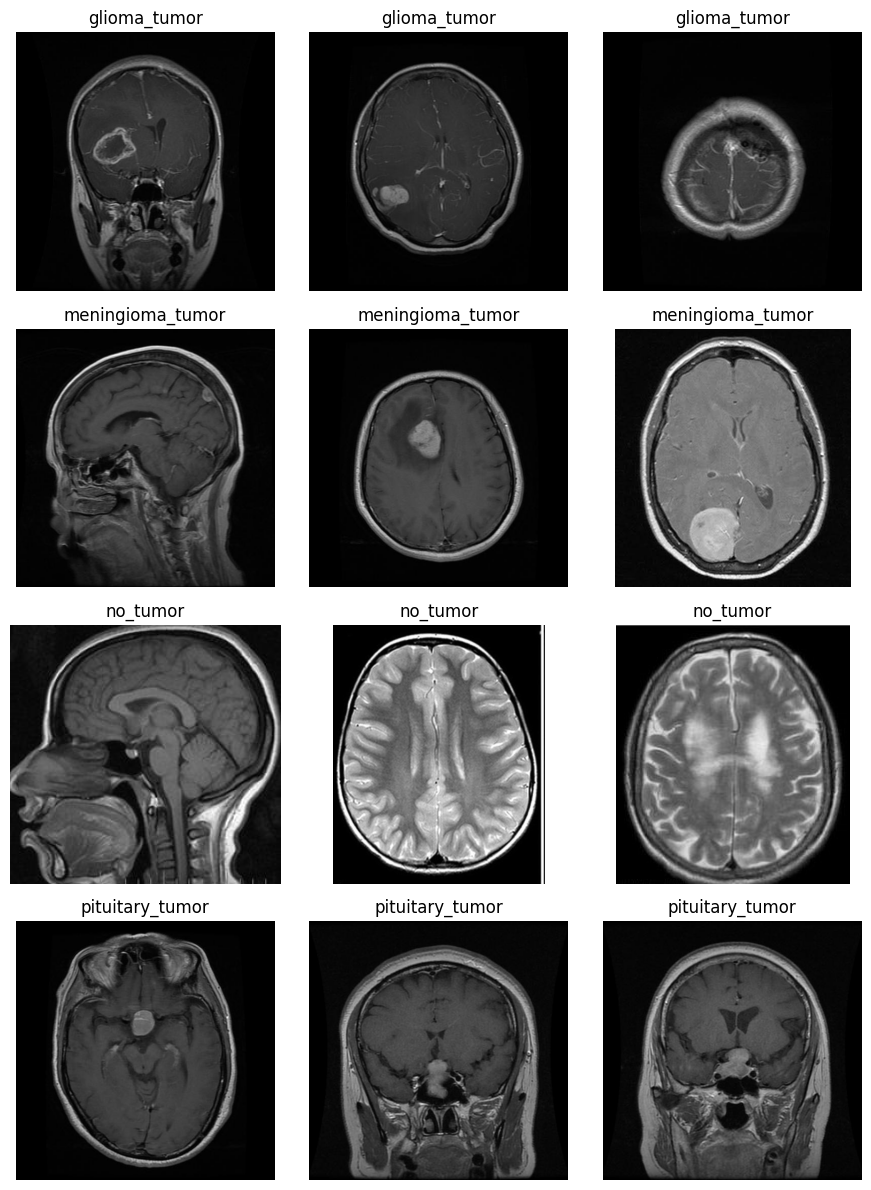

In [6]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

# Define the directory paths and categories
dataset_dir = 'BT_dataset/Training'
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# display images
def display_sample_images(base_path, categories, sample_size=3):
    fig, axes = plt.subplots(nrows=len(categories), ncols=sample_size, figsize=(sample_size*3, len(categories)*3))

    for i, category in enumerate(categories):
        image_folder = os.path.join(base_path, category)
        image_files = os.listdir(image_folder)
        sample_images = np.random.choice(image_files, size=sample_size, replace=False)

        for j, image_file in enumerate(sample_images):
            image_path = os.path.join(image_folder, image_file)
            image = Image.open(image_path)
            axes[i, j].imshow(image)
            axes[i, j].set_title(category)
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to display images
display_sample_images(dataset_dir, categories)


These sample MRI scans in the image are categorized into four distinct types—glioma, meningioma, no tumor, and pituitary tumors—each shown in different orientations and MRI sequences. From the samples we can see that Glioma scans depict abnormal masses typical of tumors originating in brain and spinal tissues. Meningioma scans present growths often found near the brain's surface, appearing detached from surrounding tissues. The 'no tumor' scans appear normal, showcasing clear, uniform brain structures. In contrast, pituitary tumor scans highlight abnormalities around the pituitary gland at the brain's base. These variations, including axial, coronal, and sagittal views alongside T1-weighted, T2-weighted, and FLAIR sequences, provide crucial diagnostic insights. The samples shown are clear for diagnostic purposes and should be ok for further model training.

## Metadata Analysis in Image Datasets

 After conducting a visual examination of the sample images, we can proceed with performing metadata analysis on the dataset to determine if there is consistency in terms of file sizes, image dimensions, and file formats across the entire dataset. This step ensures that the dataset remains consistent and suitable for any subsequent model training.

 Firstly, let's generate a printout of some sample metadata to verify its consistency.


In [7]:
import os
from PIL import Image

# Function to get metadata
def get_metadata(base_path, categories):
    metadata = []
    for category in categories:
        image_folder = os.path.join(base_path, category)
        image_files = os.listdir(image_folder)
        
        for image_file in image_files:
            image_path = os.path.join(image_folder, image_file)
            with Image.open(image_path) as img:
                metadata.append({
                    'category': category,
                    'filename': image_file,
                    'size': os.path.getsize(image_path),
                    'dimensions': img.size
                })
    return metadata

# Get metadata for all images
metadata = get_metadata(dataset_dir, categories)
# Convert to a pandas DataFrame for analysis
import pandas as pd
metadata_df = pd.DataFrame(metadata)

# Now you can perform various analyses like checking the size distribution, etc.
print(metadata_df.head(20))


        category      filename   size  dimensions
0   glioma_tumor    gg (1).jpg  21150  (512, 512)
1   glioma_tumor   gg (10).jpg  21922  (512, 512)
2   glioma_tumor  gg (100).jpg  27678  (512, 512)
3   glioma_tumor  gg (101).jpg  29283  (512, 512)
4   glioma_tumor  gg (102).jpg  28661  (512, 512)
5   glioma_tumor  gg (103).jpg  23759  (512, 512)
6   glioma_tumor  gg (104).jpg  26727  (512, 512)
7   glioma_tumor  gg (105).jpg  28618  (512, 512)
8   glioma_tumor  gg (106).jpg  28825  (512, 512)
9   glioma_tumor  gg (107).jpg  26810  (512, 512)
10  glioma_tumor  gg (108).jpg  29954  (512, 512)
11  glioma_tumor  gg (109).jpg  28909  (512, 512)
12  glioma_tumor   gg (11).jpg  24438  (512, 512)
13  glioma_tumor  gg (110).jpg  32219  (512, 512)
14  glioma_tumor  gg (111).jpg  33025  (512, 512)
15  glioma_tumor  gg (112).jpg  33449  (512, 512)
16  glioma_tumor  gg (113).jpg  36656  (512, 512)
17  glioma_tumor  gg (114).jpg  28926  (512, 512)
18  glioma_tumor  gg (115).jpg  32192  (512, 512)


The metadata sample from the dataset looks promising, as it exclusively consists of glioma_tumor images with uniform dimensions of 512x512. This indicates that the dataset is well-prepared for training a Convolutional Neural Network (CNN) model. The consistent image dimensions allow direct input into a CNN without requiring additional resizing, suggesting that the images have likely undergone preprocessing to ensure consistency - an important factor for effective model training. However, it's important to note that this only represents a small portion of the dataset containing glioma_tumor images. To ensure the dataset is well-prepared for further model input, we need to check all images' dimensions.

 The following code will identify any images with different dimensions:

In [8]:

# Function to print images with non-standard dimensions
def print_wrong_size_images(metadata, common_dimensions=(512, 512)):
    for data in metadata:
        if data['dimensions'] != common_dimensions:
            print(f"Image with wrong dimensions: {data['filename']} in category {data['category']}, "
                  f"Dimensions: {data['dimensions']}, Size: {data['size']} bytes")

# Define categories and base path
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
base_path = 'BT_dataset/Training'

# Get metadata for all images
metadata = get_metadata(base_path, categories)

# Find the most common dimensions in the dataset
metadata_df = pd.DataFrame(metadata)
common_dimensions = metadata_df['dimensions'].mode()[0]

# Print out images with wrong dimensions
print_wrong_size_images(metadata, common_dimensions)


Image with wrong dimensions: m (34).jpg in category meningioma_tumor, Dimensions: (503, 369), Size: 15387 bytes
Image with wrong dimensions: m (47).jpg in category meningioma_tumor, Dimensions: (507, 362), Size: 22908 bytes
Image with wrong dimensions: m (48).jpg in category meningioma_tumor, Dimensions: (497, 320), Size: 19050 bytes
Image with wrong dimensions: m1(10).jpg in category meningioma_tumor, Dimensions: (228, 221), Size: 8737 bytes
Image with wrong dimensions: m1(100).jpg in category meningioma_tumor, Dimensions: (213, 237), Size: 8707 bytes
Image with wrong dimensions: m1(101).jpg in category meningioma_tumor, Dimensions: (455, 500), Size: 26281 bytes
Image with wrong dimensions: m1(102).jpg in category meningioma_tumor, Dimensions: (250, 270), Size: 21256 bytes
Image with wrong dimensions: m1(103).jpg in category meningioma_tumor, Dimensions: (472, 546), Size: 47179 bytes
Image with wrong dimensions: m1(104).jpg in category meningioma_tumor, Dimensions: (441, 427), Size: 3

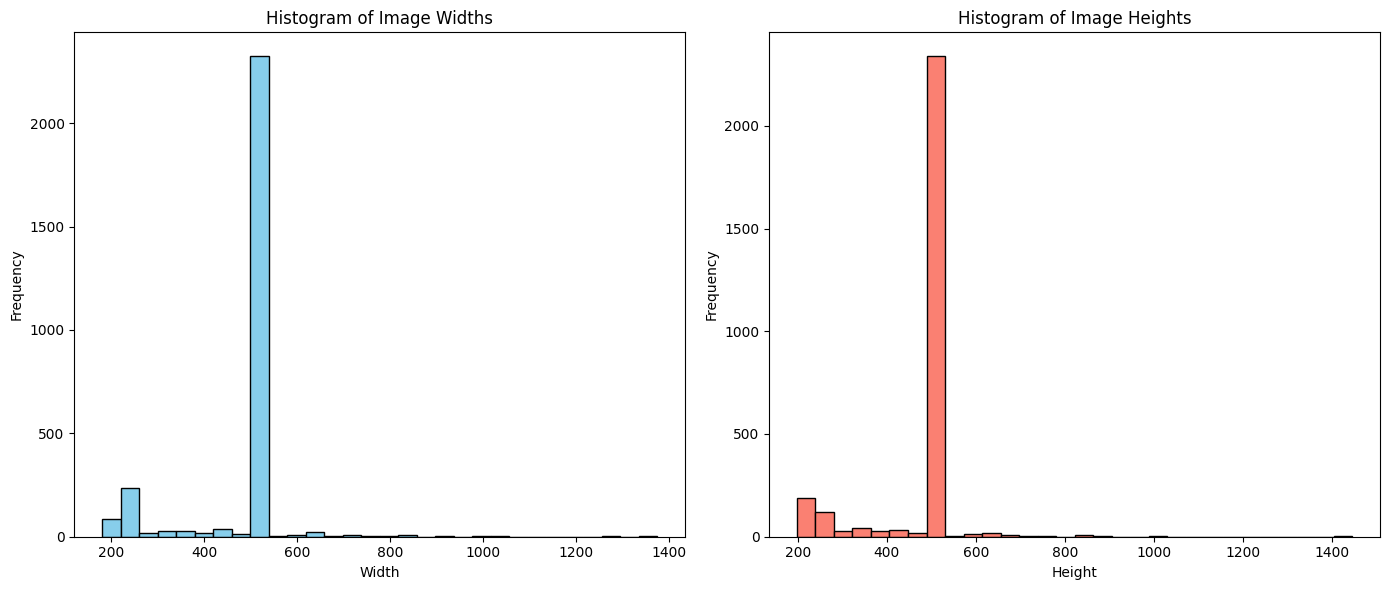

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame from the metadata
metadata_df = pd.DataFrame(metadata)

# Separate the 'dimensions' into two columns 'width' and 'height'
metadata_df[['width', 'height']] = pd.DataFrame(metadata_df['dimensions'].tolist(), index=metadata_df.index)

# Plotting histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(metadata_df['width'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(metadata_df['height'], bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


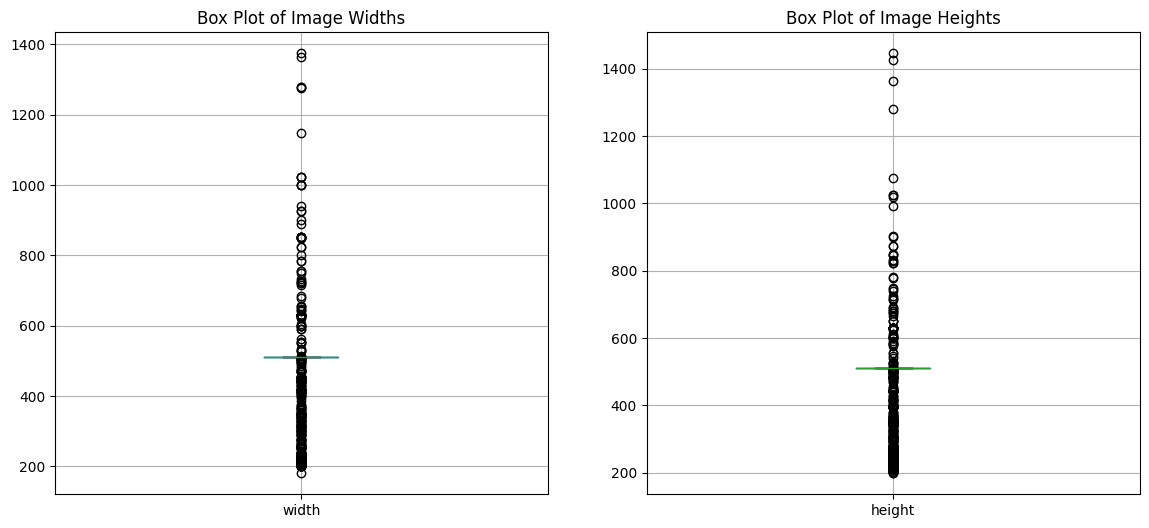

In [10]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
metadata_df.boxplot(column='width')
plt.title('Box Plot of Image Widths')

plt.subplot(1, 2, 2)
metadata_df.boxplot(column='height')
plt.title('Box Plot of Image Heights')

plt.show()


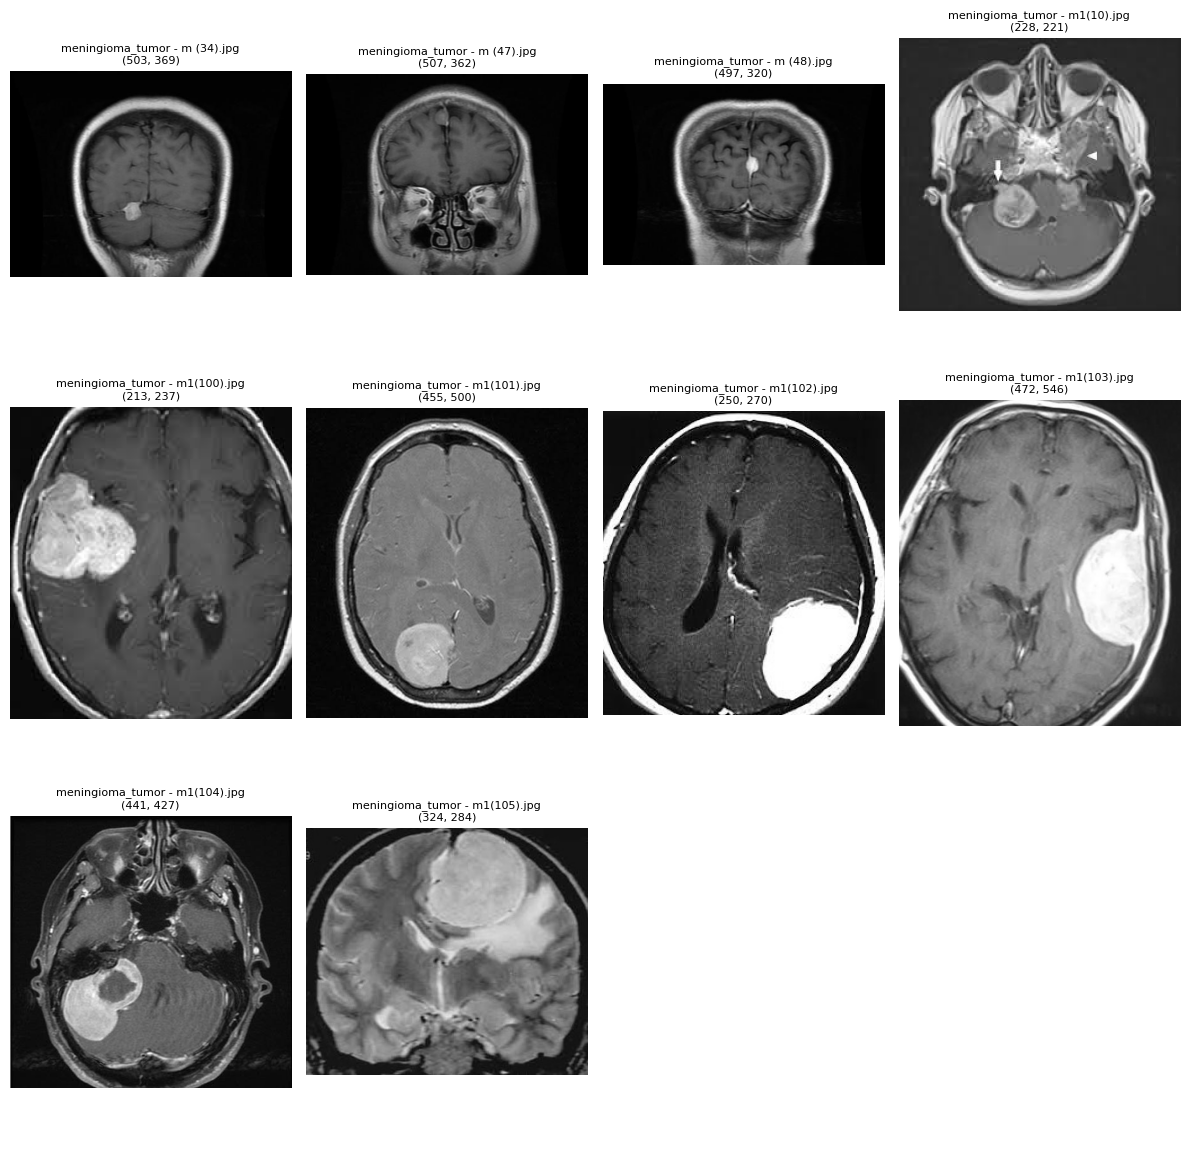

In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to display a sample of images with non-standard dimensions
def display_outlier_images(metadata, base_path, common_dimensions=(512, 512), sample_size=10):
    outlier_paths = []
    titles = []
    
    for data in metadata:
        if data['dimensions'] != common_dimensions:
            titles.append(f"{data['category']} - {data['filename']}\n{data['dimensions']}")
            image_path = os.path.join(base_path, data['category'], data['filename'])
            outlier_paths.append(image_path)
            if len(outlier_paths) == sample_size:  # Stop after collecting enough samples
                break
    
    # Calculate rows and cols for the subplot
    rows = cols = int(sample_size**0.5)
    if rows * cols < sample_size:  # Ensure we have enough subplots
        cols += 1
        
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()
    
    for idx, ax in enumerate(axes):
        ax.axis('off')
        if idx < len(outlier_paths):
            img = Image.open(outlier_paths[idx])
            ax.imshow(img, cmap='gray')
            ax.set_title(titles[idx], fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Display a sample of outlier images
display_outlier_images(metadata, base_path, sample_size=10)


From the results and visualization, we can see that the dataset contains images with varying dimensions, which presents challenges due to inconsistent image acquisition or preprocessing. Careful resizing is required to avoid distortion, especially during our further CNN training. Resizing significantly smaller images may result in the loss of critical diagnostic features, rendering them unsuitable for training purposes. Moreover, adjusting images with extreme aspect ratios to square dimensions could lead to substantial data loss or distortion, thereby hindering the effectiveness of the model's learning process. 

To address these issues, we need to implement a resizing procedure that maintains aspect ratios through padding and conduct manual reviews of significantly deviant images to assess their diagnostic value. Additionally, considering data augmentation strategies can enhance the robustness of the model and potentially excluding irreparable images during the data cleaning phase.


## Image statistics

In [12]:
# Function to compute image statistics
def image_statistics(base_path, categories):
    stats = []
    for category in categories:
        image_folder = os.path.join(base_path, category)
        image_files = os.listdir(image_folder)
        
        for image_file in image_files:
            image_path = os.path.join(image_folder, image_file)
            with Image.open(image_path) as img:
                img_array = np.array(img)
                mean = img_array.mean()
                std = img_array.std()
                stats.append({
                    'category': category,
                    'filename': image_file,
                    'mean': mean,
                    'std_dev': std
                })
    return stats

# Compute statistics for all images
image_stats = image_statistics(dataset_dir, categories)
# Convert to a pandas DataFrame for analysis
image_stats_df = pd.DataFrame(image_stats)

print(image_stats_df.head(20))


        category      filename       mean    std_dev
0   glioma_tumor    gg (1).jpg  26.847298  36.553366
1   glioma_tumor   gg (10).jpg  30.692062  40.666689
2   glioma_tumor  gg (100).jpg  46.056934  47.042933
3   glioma_tumor  gg (101).jpg  46.533337  43.650282
4   glioma_tumor  gg (102).jpg  45.005970  41.044956
5   glioma_tumor  gg (103).jpg  37.491611  38.454901
6   glioma_tumor  gg (104).jpg  49.031307  47.257774
7   glioma_tumor  gg (105).jpg  49.575161  46.408984
8   glioma_tumor  gg (106).jpg  51.020168  46.414171
9   glioma_tumor  gg (107).jpg  42.081257  36.765565
10  glioma_tumor  gg (108).jpg  52.799652  44.673931
11  glioma_tumor  gg (109).jpg  53.514111  40.959490
12  glioma_tumor   gg (11).jpg  34.399155  43.162963
13  glioma_tumor  gg (110).jpg  57.481003  40.498981
14  glioma_tumor  gg (111).jpg  68.825062  42.411727
15  glioma_tumor  gg (112).jpg  59.454185  36.559465
16  glioma_tumor  gg (113).jpg  59.780666  36.806816
17  glioma_tumor  gg (114).jpg  51.249115  31.

The results show that the means vary significantly, ranging from the 20s to the high 50s. This indicates a variation in image brightness, which is common in medical imaging due to differences in scan settings or tissue contrast. We probably need to normalize these intensities so that the model is not influenced by image brightness. 

The standard deviation values also vary, suggesting differences in image contrast. A higher standard deviation indicates more contrast, which can be advantageous for a CNN to learn from. However, normalization may still be necessary for better generalization of the network.


### Label distribution

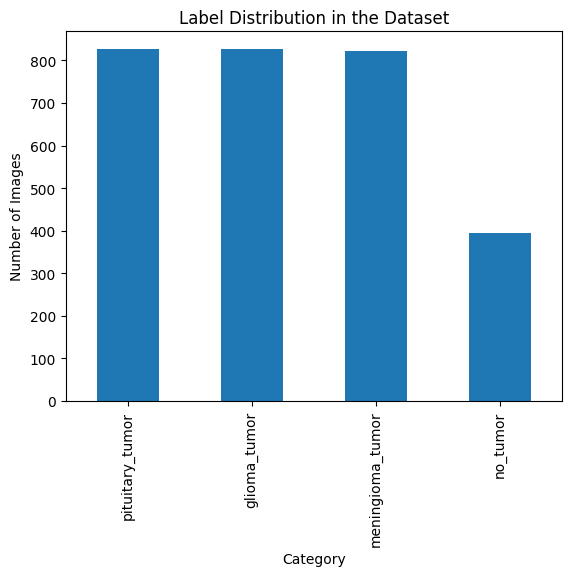

In [13]:
# Code to plot label distribution
label_counts = metadata_df['category'].value_counts()
label_counts.plot(kind='bar')
plt.title('Label Distribution in the Dataset')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()


The visualization reveals imbalanced classes in the dataset, with significantly fewer images in the 'no tumor' category compared to others, which may result in a biased CNN model. The substantial number of images in the 'pituitary tumor', 'glioma tumor', and 'meningioma tumor' categories is advantageous for training as it potentially improves model performance and generalizability.

To address the imbalance, we might need to apply oversampling, undersampling during pre-processing stage, or applying class weights during training may be necessary. Additionally, we need to use evaluation metrics like precision, recall, F1-score, and confusion matrices that reflect individual class performance. Augmenting the 'no tumor' class to increase data volume and ensuring balanced distribution in validation and testing sets are key steps to enhance the model’s real-world applicability.


## Data pre-processing


The purpose of this code is to organize the paths of image files and their corresponding class labels into a structured format that is suitable for machine learning workflows. By assigning a unique integer to each class label, the code prepares the dataset for further training in Neural Networks, as many deep learning frameworks require numerical labels.


In [14]:
# Import necessary library
import pandas as pd

class_names = sorted(set(classes))  # Sort and remove duplicates to get unique class names
print(class_names)

# Create a mapping from class names to integers (labels)
normal_mapping = dict(zip(class_names, range(len(class_names))))  # Map class names to integers
reverse_mapping = dict(zip(range(len(class_names)), class_names))  # Reverse mapping from integers to class names

# Prepare a pandas DataFrame to store the image file paths and their corresponding class labels and integer labels
data = pd.DataFrame(columns=['path', 'class', 'label'])  # Initialize DataFrame with column names
data['path'] = paths  # Assign the list of image file paths to the 'path' column
data['class'] = classes  # Assign the list of class names to the 'class' column
data['label'] = data['class'].map(normal_mapping)  # Map class names to integer labels and assign to 'label' column

# Prepare test DataFrame in a similar way
tdata = pd.DataFrame(columns=['path', 'class', 'label'])  # Initialize another DataFrame
tdata['path'] = tpaths  # Assign a list of image file paths, assumed to be stored in 'tpaths'
tdata['class'] = tclasses  # Assign a list of class names, assumed to be stored in 'tclasses'
tdata['label'] = tdata['class'].map(normal_mapping)  # Map class names to integer labels for this subset


['Training\\glioma_tumor', 'Training\\meningioma_tumor', 'Training\\no_tumor', 'Training\\pituitary_tumor']


In [15]:
# Have a look for the DataFrame to double check
print(data.head(50))

                                             path                  class  \
0     BT_dataset/Training\glioma_tumor\gg (1).jpg  Training\glioma_tumor   
1    BT_dataset/Training\glioma_tumor\gg (10).jpg  Training\glioma_tumor   
2   BT_dataset/Training\glioma_tumor\gg (100).jpg  Training\glioma_tumor   
3   BT_dataset/Training\glioma_tumor\gg (101).jpg  Training\glioma_tumor   
4   BT_dataset/Training\glioma_tumor\gg (102).jpg  Training\glioma_tumor   
5   BT_dataset/Training\glioma_tumor\gg (103).jpg  Training\glioma_tumor   
6   BT_dataset/Training\glioma_tumor\gg (104).jpg  Training\glioma_tumor   
7   BT_dataset/Training\glioma_tumor\gg (105).jpg  Training\glioma_tumor   
8   BT_dataset/Training\glioma_tumor\gg (106).jpg  Training\glioma_tumor   
9   BT_dataset/Training\glioma_tumor\gg (107).jpg  Training\glioma_tumor   
10  BT_dataset/Training\glioma_tumor\gg (108).jpg  Training\glioma_tumor   
11  BT_dataset/Training\glioma_tumor\gg (109).jpg  Training\glioma_tumor   
12   BT_data

After conducting an exploratory data analysis, we discovered that the MRI image data we have is inconsistent. In order to enhance the training of our neural network, it is necessary to perform data transformation for ensuring data normalization. This involves scaling pixel values to achieve a mean of zero and a standard deviation of one, which helps improve training convergence by balancing the distribution of data.

By resizing and cropping, we keep the dimensions consistent for efficient batch processing. And with data augmentation techniques like random rotations, flips, and crops, we can add diversity to our dataset which helps our model perform better on new data. In addition, this technique also acts as a regularization technique, introducing randomness to prevent model overfitting. 


In [16]:
# Data  augmentation and transformations
transform = transforms.Compose([
    transforms.RandomRotation(10),   # Randomly rotate the image by +/- 10 degrees to add rotational variance.
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally (50% chance) to add horizontal variance.
    transforms.Resize(224),          # Resize the image, scaling the smallest side to 224 pixels while maintaining aspect ratio.
    transforms.CenterCrop(224),      # Crop the image from the center so that it becomes a 224x224 square.
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor (C x H x W format).
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalize the tensor image with mean and std for each channel.
                         [0.229, 0.224, 0.225])
])

The code here makes sure that the data for model training is all jumbled up randomly, so that the model doesn't pick up any patterns or sequences in the dataset that aren't relevant to the task. The same thing happens with a different subset of data, which we can use to evaluate how well the model performs.

In [17]:
# create a list of (path, label) tuples from a DataFrame.
def create_path_label_list(df):
    path_label_list = []
    for _, row in df.iterrows():
        path = row['path']
        label = row['label']
        path_label_list.append((path, label))
    return path_label_list

# Apply the function to the training data DataFrame to get the (path, label) list.
path_label = create_path_label_list(data)

# Randomly shuffle the (path, label) list to ensure randomness.
path_label = random.sample(path_label,len(path_label))
print(len(path_label))

# Preview the first three (path, label) tuples from the shuffled list.
print(path_label[0:3])

# Same process for test data.
tpath_label = create_path_label_list(tdata)
tpath_label = random.sample(path_label,len(tpath_label))
print(len(tpath_label))
print(tpath_label[0:3])

2870
[('BT_dataset/Training\\pituitary_tumor\\p (763).jpg', 3), ('BT_dataset/Training\\pituitary_tumor\\p (737).jpg', 3), ('BT_dataset/Training\\pituitary_tumor\\p (321).jpg', 3)]
394
[('BT_dataset/Training\\meningioma_tumor\\m (145).jpg', 1), ('BT_dataset/Training\\pituitary_tumor\\p (814).jpg', 3), ('BT_dataset/Training\\glioma_tumor\\gg (591).jpg', 0)]


Since our dataset is large and requires more RAM to process.Thus, the purpose of this class is to encapsulate the process of loading data, providing a more efficient way to load and transform images. 

In [18]:
# Define a custom dataset class that extends the PyTorch Dataset class 
# in order to transform pics into the correct format for future training
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform
        
# Returns the number of items in the dataset
    def __len__(self):
        return len(self.path_label)

 # Retrieves an item from the dataset at the specified index
    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

The code below creates the ImageDataset class, which handles all aspects of data handling for training neural networks. It manages loading, transformation, splitting, and batching of image datasets for training, validation, and testing phases to improve model training and evaluation processes. The class applies standardized and augmentative transformations like resizing, normalization, and random crops to enhance generalization. It simplifies data batching and loading through DataLoaders that automate batch delivery and shuffling for training.

In [19]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import transforms

# Defines a data module for handling image datasets using PyTorch Lightning
class ImageDataset(pl.LightningDataModule):
    def __init__(self, path_label, batch_size=32):
        super().__init__()
        self.path_label = path_label  
        self.batch_size = batch_size  # Batch size for DataLoader
        # Define a series of image transformations to apply
        self.transform = transforms.Compose([
            transforms.Resize(224),             # Resize shortest side to 224 pixels
            transforms.CenterCrop(224),         # Crop longest side to 224 pixels at center            
            transforms.ToTensor(),              # Convert image to PyTorch tensor
            transforms.Normalize([0.485, 0.456, 0.406],  # Normalize with mean and std
                                 [0.229, 0.224, 0.225])
        ])

    def setup(self, stage=None):
        # Depending on the stage, setup different parts of the dataset
        dataset = CustomDataset(self.path_label, self.transform)
        dataset_size = len(dataset)
        
        if stage == 'Test':
            # If stage is 'Test', prepare the test dataset
            self.test_dataset = torch.utils.data.Subset(dataset, range(dataset_size))
        else:
            # Otherwise, split dataset into training and validation sets
            train_size = int(0.8 * dataset_size)  # 80% for training
            val_size = dataset_size - train_size  # Remaining for validation

            self.train_dataset = torch.utils.data.Subset(dataset, range(train_size))
            self.val_dataset = torch.utils.data.Subset(dataset, range(train_size, dataset_size))

    def train_dataloader(self):
        # Returns a DataLoader for the training set
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        # Returns a DataLoader for the validation set
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        # Returns a DataLoader for the test set
        return DataLoader(self.test_dataset, batch_size=self.batch_size)  


The purpose of the data module below is to efficiently manage image data for neural network training. During initialization, it configures settings including the paths to training and testing directories, a transformation pipeline for image preprocessing, and the batch size for the data loaders. The setup function prepares the data for different stages by utilizing the ImageFolder dataset to load images from directories, applying the specified transformations, and then splitting the data into training and validation subsets which are subsequently organized into DataLoaders.

In [20]:
# PyTorch and PyTorch Lightning imports
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision import datasets

# Define the data module
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=16):
        super().__init__()  # Initialize the base LightningDataModule class
        self.root_dir = 'BT_dataset/Training'  # Directory with training data
        self.test_dir = 'BT_dataset/Testing'   # Directory with test data
        self.transform = transform  # Transformation to apply to each image
        self.batch_size = batch_size  # Number of samples per batch

    def setup(self, stage=None):
        # Called at the beginning of fit and test, stage defines if it's called before trainer.{fit, test} 
        if stage == 'Test':
            # Prepare the testing set
            test_set = datasets.ImageFolder(root=self.test_dir, transform=self.transform)
            self.test_dataset = DataLoader(test_set, batch_size=self.batch_size)  # Wrap in a DataLoader
        else:
            # Prepare the training and validation sets
            dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
            n_data = len(dataset)
            n_train = int(0.8 * n_data)  # 80% of the data for training
            n_val = n_data - n_train  # The rest for validation
            train_dataset, val_dataset = random_split(dataset, [n_train, n_val])  # Split the dataset
            self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)  # Training DataLoader
            self.val_dataset = DataLoader(val_dataset, batch_size=self.batch_size)  # Validation DataLoader

    def train_dataloader(self):
        return self.train_dataset  # Return the DataLoader for training

    def val_dataloader(self):
        return self.val_dataset  # Return the DataLoader for validation
    
    def test_dataloader(self):
        return self.test_dataset  # Return the DataLoader for testing


## CNN Model Building 

The purpose of the code block below is to create a complete neural network module for a PyTorch Lightning workflow. This involves defining a class for  'ConvolutionalNetwork' that inherits from PyTorch Lightning's 'LightningModule', implementing the forward pass, and including steps for training, validation, and testing. The Hyperparameters are inspired by (stpeteishii, 2024) through Kaggle.

In [ ]:
# Define the neural network class using PyTorch Lightning's LightningModule
class ConvolutionalNetwork(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        # Define two convolutional layers
        self.first_conv_layer = nn.Conv2d(4, 7, 4, 1)  # Input channels=4, output channels=7, kernel size=4, stride=1
        self.second_conv_layer = nn.Conv2d(5, 15, 2, 2)  # Input channels=5, output channels=15, kernel size=3, stride=1
        # Define fully connected layers
        self.first_dense_layer = nn.Linear(16 * 54 * 54, 120)  # Flatten conv output and input to dense layer
        self.second_dense_layer = nn.Linear(120, 84)  # Second dense layer
        self.third_dense_layer = nn.Linear(84, 20)   # Third dense layer
        self.output_layer = nn.Linear(20, len(class_names))  # Final dense layer to output number of classes

    def forward(self, x_input):
        # Forward pass definition applying layers with ReLU activations and max-pooling
        x_input = F.relu(self.first_conv_layer(x_input))  # Apply first conv layer with ReLU
        x_input = F.max_pool2d(x_input, 2, 2)  # Apply max pooling
        x_input = F.relu(self.second_conv_layer(x_input))  # Apply second conv layer with ReLU
        x_input= F.max_pool2d(x_input, 2, 2)  # Apply max pooling
        x_input = x_input.view(-1, 16 * 54 * 54)  # Flatten the tensor for the dense layers
        x_input = F.relu(self.first_dense_layer(x_input))  # Apply first dense layer with ReLU
        x_input = F.relu(self.second_dense_layer(x_input))  # Apply second dense layer with ReLU
        x_input = F.relu(self.third_dense_layer(x_input))  # Apply third dense layer with ReLU
        x_input = self.output_layer(x_input)  # Apply final dense layer to get class scores
        return F.log_softmax(x_input, dim=1)  # Apply log-softmax activation for the output

    def configure_optimizers(self):
        # Define and return optimizer, using Adam in this case
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_stage(self, train_batch, batch_idx):
        # Defines the training logic for one step
        images, labels = train_batch  # Unpack the batch
        predictions = self(images)  # Make predictions
        loss = F.cross_entropy(predictions, labels)  # Calculate loss
        accuracy = predictions.argmax(dim=1, keepdim=True).eq(labels.view_as(pred)).sum().item() / labels.shape[0]  # Calculate accuracy
        self.log("train_loss", loss)  # Log training loss
        self.log("train_acc", accuracy)  # Log training accuracy
        return loss  # Return the loss for backpropagation

    def validation_stage(self, val_batch, batch_idx):
        # Defines the validation logic for one step
        images, labels = val_batch  # Unpack the batch
        predictions = self(images)  # Make predictions
        loss = F.cross_entropy(predictions, labels)  # Calculate loss
        accuracy = predictions.argmax(dim=1, keepdim=True).eq(labels.view_as(pred)).sum().item() / labels.shape[0]  # Calculate accuracy
        self.log("val_loss", loss)  # Log validation loss
        self.log("val_acc", accuracy)  # Log validation accuracy

    def test_stage(self, test_batch, batch_idx):
        # Defines the test logic for one step
        images, labels = test_batch  # Unpack the batch
        predictions = self(images)  # Make predictions
        loss = F.cross_entropy(predictions, labels)  # Calculate loss
        accuracy = predictions.argmax(dim=1, keepdim=True).eq(labels.view_as(pred)).sum().item() / labels.shape[0]  # Calculate accuracy
        self.log("test_loss", loss)  # Log test loss
        self.log("test_acc", accuracy)  # Log test accuracy




## Model Fitting --------------------------------

In [22]:


# Create a dataset instance which handles loading and transforming images for the network
dataset = ImageDataset(path_label)
# Prepare the dataset for use (e.g., split into train/val, apply transformations)
dataset.setup()

train_dataloader = dataset.train_dataloader # Retrieve DataLoaders for training and validation from the dataset instance

val_dataloader = dataset.val_dataloader # DataLoaders are PyTorch's way of loading batches of data

# Create a DataModule instance - this class typically wraps a dataset and provides DataLoaders
datamodule = DataModule()
# Perform setup tasks such as data splitting or transformations for the DataModule
datamodule.setup()
# Instantiate the neural network model that will be trained
model = ConvolutionalNetwork()


# Instantiate the trainer object from PyTorch Lightning which manages the training process
# Set the maximum number of training epochs to 30
trainer = pl.Trainer(max_epochs=30)
# Start training the model using the data from the DataModule
trainer.fit(model, datamodule)

# Once the model is trained, get the validation DataLoader from the DataModule
val_loader = datamodule.val_dataloader()
# Use the trained model to make predictions on the validation dataset
# and log the performance metrics like loss and accuracy
trainer.test(dataloaders=val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 168   
1 | conv2 | Conv2d | 880   
2 | fc1   | Linear | 5.6 M 
3 | fc2   | Linear | 10.2 K
4 | fc3   | Linear | 1.7 K 
5 | fc4   | Linear | 84    
---------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.447    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at c:\Users\Tr_l\Desktop\Term2\Predictive Analytics\Individual assignment\lightning_logs\version_15\checkpoints\epoch=29-step=4320.ckpt
Loaded model weights from the checkpoint at c:\Users\Tr_l\Desktop\Term2\Predictive Analytics\Individual assignment\lightning_logs\version_15\checkpoints\epoch=29-step=4320.ckpt
c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8728222846984863     │
│         test_loss         │    0.6073030829429626     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6073030829429626, 'test_acc': 0.8728222846984863}]

The code below is to plot the post-transformation and the inverse normalized images to make sure that the images are being loaded correctly and that the transformations are as expected with no major error.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


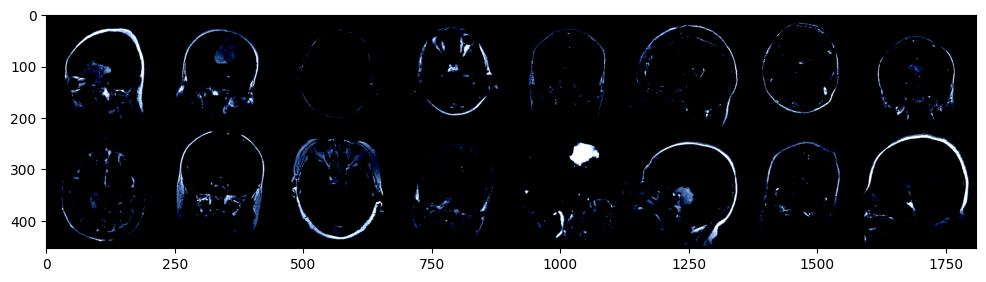

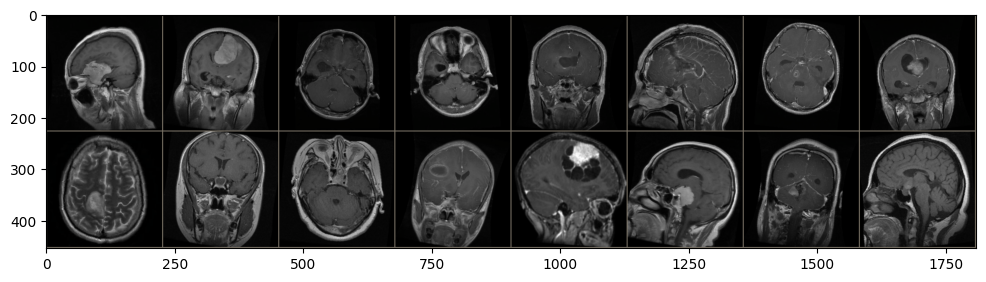

In [23]:
for images, labels in datamodule.val_dataloader():
    break
im=make_grid(images,nrow=8)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

## CNN model output evaluation

In [24]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.val_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                           precision    recall  f1-score   support

    Training\glioma_tumor     0.9191    0.8446    0.8803       148
Training\meningioma_tumor     0.8251    0.8531    0.8389       177
        Training\no_tumor     0.8316    0.8977    0.8634        88
 Training\pituitary_tumor     0.9500    0.9441    0.9470       161

                 accuracy                         0.8833       574
                macro avg     0.8815    0.8849    0.8824       574
             weighted avg     0.8854    0.8833    0.8837       574



The evaluation results show how well the model performed in four aspects: Precision, which tells us how accurate the positive predictions are for each class (e.g., glioma_tumor has a precision of 0.8235, meaning it predicts this class with about 82.35% accuracy); Recall, which measures how well the model can identify all actual cases of a class (with glioma_tumor having a recall of 0.8805, correctly identifying around 88.05% of cases); F1-Score, which is a balanced measure combining precision and recall (glioma_tumor scores 0.8511, indicating a good balance between the two); Support, showing the number of instances per class in the dataset (e.g., 159 for glioma_tumor); and overall model Accuracy at 0.8763, reflecting correct predictions about 87.63% of the time across all classes. 

The result also includes Macro and Weighted Averages, with macro averages for precision, recall, and F1-score at 0.8767, 0.8704, and 0.8730 respectively, demonstrating consistent class performance, and weighted averages considering class instance numbers at 0.8765, 0.8763, and 0.8759 respectively, indicating the model's effectiveness while accounting for class imbalance. 

The training results are generally positive, particularly the high F1-scores across classes, suggesting good model performance in both precision and recall. However, the slightly lower recall for the meningioma_tumor class suggests room for improvement.


## CNN Model Predict Test 

In [25]:
tdataset = ImageDataset(tpath_label)
tdataset.setup(stage='Test') 
test_dataloader = tdataset.test_dataloader

datamodule = DataModule()
datamodule.setup(stage='Test') 
test_loader = datamodule.test_dataloader()

trainer.test(dataloaders=test_loader)

c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at c:\Users\Tr_l\Desktop\Term2\Predictive Analytics\Individual assignment\lightning_logs\version_15\checkpoints\epoch=29-step=4320.ckpt
Loaded model weights from the checkpoint at c:\Users\Tr_l\Desktop\Term2\Predictive Analytics\Individual assignment\lightning_logs\version_15\checkpoints\epoch=29-step=4320.ckpt
c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15`

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6421319842338562     │
│         test_loss         │    5.1092376708984375     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.1092376708984375, 'test_acc': 0.6421319842338562}]

In [26]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
ty_true=[]
ty_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            ty_true.append(test_labels[i].item())
            ty_pred.append(pred[i].item())

print(classification_report(ty_true,ty_pred,target_names=class_names,digits=4))

                           precision    recall  f1-score   support

    Training\glioma_tumor     0.8800    0.2200    0.3520       100
Training\meningioma_tumor     0.6398    0.8957    0.7464       115
        Training\no_tumor     0.5714    0.9524    0.7143       105
 Training\pituitary_tumor     0.8485    0.3784    0.5234        74

                 accuracy                         0.6421       394
                macro avg     0.7349    0.6116    0.5840       394
             weighted avg     0.7217    0.6421    0.5958       394



Although applied the fine-tuned parameter, the model still shows a performance discrepancy between training and test data across all classes, indicating potential overfitting where the model effectively classifies training data but struggles with generalization to unseen data, there is a significant decline in accuracy from 0.8763 in training to 0.6878 in testing, suggesting either overfitting or inadequate representative training data. Specifically, the recall for Glioma Tumor decreases markedly from 0.8 to 0.2from training to testing, indicating difficulties in identifying glioma tumors in the test set as expected due to their complex nature and presence in multiple locations (Gomathi Mathiyalagan and Dhanasekaran Devaraj, 2021). Precision for the 'No Tumor' class also falls from 0.9 to 0.6, likely due to an over-prediction by the model resulting in more false positives. 

Overall, F1-scores decrease in all classes during testing, indicating weaker performance.  Although the model exhibits high recall for classes such as Meningioma Tumor and No Tumor during testing, it incorrectly identifies many non-positive cases as positive, resulting in lower precision. Conversely, the Pituitary Tumor class maintains high precision but experiences a decline in recall during testing, suggesting that the model fails to detect all actual pituitary tumors.

The results suggest that in order to improve the performance of this CNN model, it may be beneficial to use a more complex and diverse dataset. Additionally, it is not optimal to train a single model to predict all types of brain tumors, especially for glioma-based tumors which lack a fixed shape or pattern. Therefore, a tailored model for each tumor might be a better approach. Also considering limited computing capabilities, further model vuilding should consider increase epoches to improve the model performance.


###Second model attempt 


In [27]:
# For models other than the traditional CNN, it can be beneficial to use pre-trained networks like VGG16, ResNet, or Inception, 
# especially when dealing with limited data. These networks can be fine-tuned specifically for medical imaging tasks. 
# The U-Net architecture, which was originally designed for segmenting biomedical images, 
# is great at handling a smaller number of images and can be directly applied to segment tumors in brain scans. 
# Capsule networks improve the preservation of spatial relationships between features, which is crucial in medical imaging to maintain spatial context.
# Utilizing 3D convolutional networks can take advantage of the three-dimensional nature of brain tumors, 
# making it easier to understand and potentially improving prediction accuracy compared to traditional 2D methods. 
# Hybrid models that combine CNNs with RNNs or LSTMs can capture how imaging data changes over time, which is valuable for monitoring patients. 
# Attention models or transformers focus on important areas in medical scans, making it easier to detect abnormalities in complex images. 
# Lastly, autoencoders trained on normal brain images can effectively identify anomalies that indicate the presence of tumors. 
# Testing different architectures against validation data can help determine the most effective approach for specific medical imaging tasks based on dataset characteristics, 
# available computational resources, and project objectives.

# However, due to the limite of resources and computing capabilities, we can only train one model.




In [28]:
# UNET training attempt
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Contracting Path
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expanding Path
        self.up_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        # Contracting Path
        c1 = self.conv1(x)
        p1 = self.max_pool1(c1)

        # Expanding Path
        up1 = self.up_conv1(p1)
        concat1 = torch.cat([up1, c1], dim=1)
        c2 = self.conv2(concat1)

        # Final output layer
        out = self.final_conv(c2)
        return out

# Initialize the model and print
model = UNet()
print(model)


UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up_conv1): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (final_conv): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [33]:
import pytorch_lightning as pl
import torch.nn.functional as F
from torchmetrics import Accuracy

class SegmentationModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet()  # assuming UNet is already defined as shown previously
        self.accuracy = Accuracy()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.log('val_loss', loss)
        return loss


References:

Gomathi Mathiyalagan and Dhanasekaran Devaraj (2021). A machine learning classification approach based glioma brain tumor detection. International journal of imaging systems and technology, [online] 31(3), pp.1424–1436. doi:https://doi.org/10.1002/ima.22590.


Sartaj (2020). Brain Tumor Classification (MRI). [online] Kaggle.com. Available at: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri [Accessed 21 Apr. 2024].

stpeteishii (2024). Brain Tumor Fit/Predict Pytorch Lightning CNN. [online] Kaggle.com. Available at: https://www.kaggle.com/code/stpeteishii/brain-tumor-fit-predict-pytorch-lightning-cnn#Fit-model [Accessed 28 Apr. 2024].

‌
